## Build a handwritten digit recognition application


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Training dataset size: 60000
Test dataset size: 10000


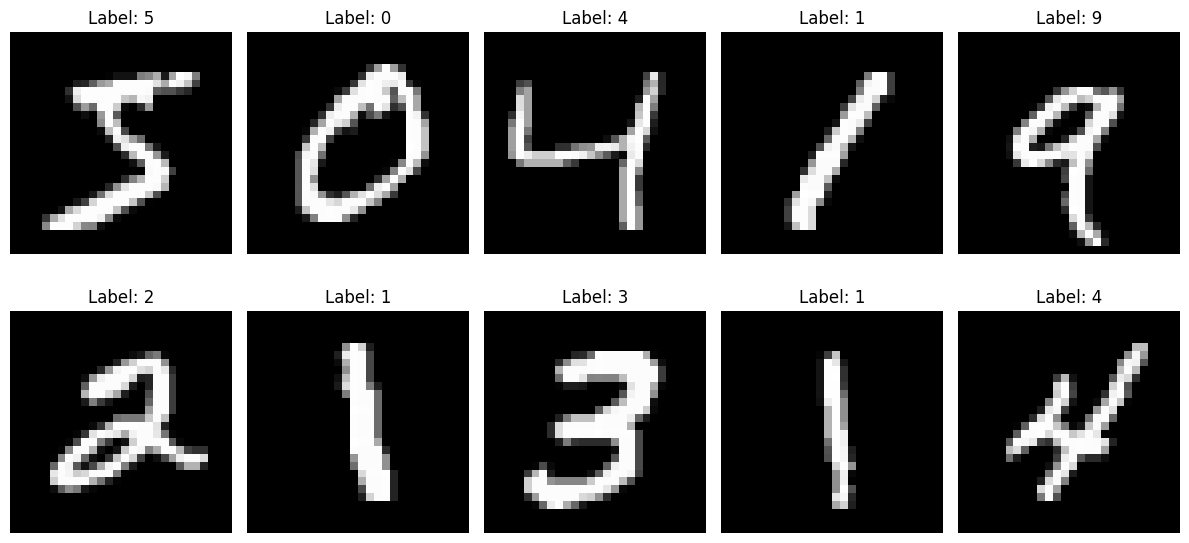


Image shape: torch.Size([1, 28, 28])

Class distribution in training set:
Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples


In [9]:
# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")



# Display a grid of sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    # Get a sample image and its label
    image, label = train_dataset[i]
    # Convert the tensor to numpy and reshape
    image = image.squeeze().numpy()
    # Display the image
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {label}')
plt.tight_layout()
plt.show()

# Print the shape of a single image
image, _ = train_dataset[0]
print(f"\nImage shape: {image.shape}")

# Print class distribution
from collections import Counter
train_labels = [label for _, label in train_dataset]
label_counts = Counter(train_labels)
print("\nClass distribution in training set:")
for label, count in sorted(label_counts.items()):
    print(f"Digit {label}: {count} samples")

In [11]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [ ]:

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:


# Training loop
def train(epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss = {running_loss / 100:.3f}')
                running_loss = 0.0

# Train the model
print("Training started...")
train(epochs=5)



Training started...
Epoch 1, Batch 100: Loss = 0.448
Epoch 1, Batch 200: Loss = 0.148
Epoch 1, Batch 300: Loss = 0.126
Epoch 1, Batch 400: Loss = 0.100
Epoch 1, Batch 500: Loss = 0.100
Epoch 1, Batch 600: Loss = 0.080
Epoch 1, Batch 700: Loss = 0.081
Epoch 1, Batch 800: Loss = 0.097
Epoch 1, Batch 900: Loss = 0.079
Epoch 2, Batch 100: Loss = 0.075
Epoch 2, Batch 200: Loss = 0.063
Epoch 2, Batch 300: Loss = 0.068
Epoch 2, Batch 400: Loss = 0.068
Epoch 2, Batch 500: Loss = 0.082
Epoch 2, Batch 600: Loss = 0.072
Epoch 2, Batch 700: Loss = 0.069
Epoch 2, Batch 800: Loss = 0.069
Epoch 2, Batch 900: Loss = 0.081
Epoch 3, Batch 100: Loss = 0.053
Epoch 3, Batch 200: Loss = 0.046
Epoch 3, Batch 300: Loss = 0.053


KeyboardInterrupt: 

In [19]:
# lets visualize the model
# on your terminal run `brew install graphviz`
from torchviz import make_dot
# get a sample input from the test dataset
image, _ = test_dataset[0]
sample_input = image.unsqueeze(0).to(device)
output = model(sample_input)
dot = make_dot(output, params=dict(list(model.named_parameters())))
dot.render("model_architecture", format="png")


'model_architecture.png'

In [22]:
# Testing function
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Accuracy on test set: {100 * correct / total:.2f}%')



# Test the model
print("\nTesting the model...")
test()


Testing the model...
Accuracy on test set: 98.78%


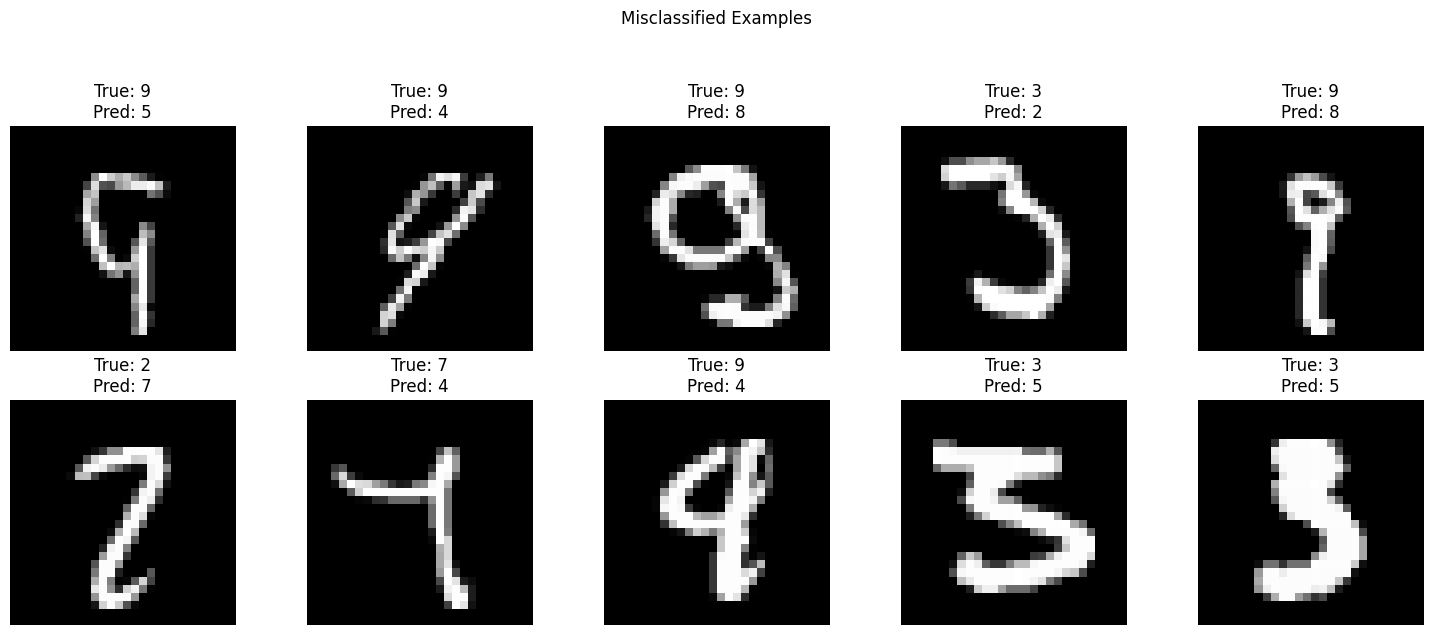

In [23]:
# Visualize the model predictions vs the actual labels and the image for a few samples where the model made a mistake

# Get predictions and actual labels for misclassified examples
model.eval()
misclassified_examples = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Find indices where predictions were wrong
        mask = (predicted != labels)
        misclassified_images = images[mask]
        misclassified_labels = labels[mask]
        misclassified_preds = predicted[mask]
        
        # Store the first few misclassified examples
        for img, true_label, pred_label in zip(misclassified_images, misclassified_labels, misclassified_preds):
            misclassified_examples.append((img, true_label.item(), pred_label.item()))
            if len(misclassified_examples) >= 10:  # Store only first 10 mistakes
                break
        if len(misclassified_examples) >= 10:
            break

# Display the misclassified examples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (img, true_label, pred_label) in enumerate(misclassified_examples[:10]):
    ax = axes[i//5, i%5]
    # Convert the tensor to numpy and reshape
    img = img.cpu().squeeze().numpy()
    # Display the image
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'True: {true_label}\nPred: {pred_label}')
plt.suptitle('Misclassified Examples', y=1.05)
plt.tight_layout()
plt.show()

In [29]:
# build a simple web app to recognize digits using gradio. The app should have a sketchpad to draw a digit and the app should predict the digit.
import gradio as gr
import torch
import numpy as np
from PIL import Image

def predict_digit(image):
    # Preprocess the image
    if image is None:
        return None
    
    try:
        # Extract the actual image data from the Gradio input
        if isinstance(image, dict):
            image = image['composite']
        
        # Convert to grayscale and resize to 28x28
        image = Image.fromarray(image).convert('L')
        image = image.resize((28, 28))
        
        # Convert to tensor and normalize
        image = torch.tensor(np.array(image), dtype=torch.float32)
        image = image / 255.0  # Normalize to [0,1]
        image = (image - 0.1307) / 0.3081  # Apply same normalization as training data
        
        # Reshape and add batch dimension
        image = image.reshape(1, 1, 28, 28)
        image = image.to(device)
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            output = model(image)
            probabilities = torch.nn.functional.softmax(output, dim=1)[0]
            
            # Get all probabilities and sort them
            probs_with_labels = [(digit, prob.item()) for digit, prob in enumerate(probabilities)]
            sorted_probs = sorted(probs_with_labels, key=lambda x: x[1], reverse=True)
            
            # Format the output
            result = "Predictions (sorted by confidence):\n\n"
            for digit, prob in sorted_probs:
                result += f"Digit {digit}: {prob:.2%}\n"
            
            return result
    
    except Exception as e:
        return f"Error processing image: {str(e)}"


# Create Gradio interface
iface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Sketchpad(),
    outputs="text",
    live=True,
    title="Handwritten Digit Recognition",
    description="Draw a digit (0-9) and the model will predict it in real-time!",
    examples=[],
)

# Launch the app
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://ca3f3a2a45c49ec2d8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
